<a href="https://www.kaggle.com/code/vainero/toxic-comments-1d-convolutions-with-keras?scriptVersionId=111648438" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<img src="https://github.com/vainero/Files/blob/main/Toxic.gif?raw=true"> 

### Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


### Loading Data

In [2]:
train_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip').fillna(' ')

# Here is a sample of the data
train_df.sample(10, random_state = 1234)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
12345,20bc45f5014c1eca,"""\n\nYour latest edit has again had to be remo...",0,0,0,0,0,0
55587,948580166b8b8745,"""\n\nWorks for me. BaStun not BaTsun """,0,0,0,0,0,0
16877,2c8519885db5c0bb,List of newspapers in India by readership\n\nT...,0,0,0,0,0,0
140039,ed64d530a34aa973,Happy New Years\nCheers ),0,0,0,0,0,0
125777,a0dd897eafbada2c,Photos \nSouthwestern’s official website has m...,0,0,0,0,0,0
159512,ff2f5695bb9aa845,"How's this? It's a lot shorter, but it's more ...",0,0,0,0,0,0
121612,8aa46e67645e4b7b,Why did you remove skinwalker instead of movin...,0,0,0,0,0,0
7588,142d9e745d03c9ef,"""I repeat, the text was about a minority schoo...",0,0,0,0,0,0
9463,191a1c6bd40ad470,bay pigs article \n\nhi i noticed that you wer...,1,0,1,0,0,0
103236,287b2d375ed7188a,"MusikAnimal is a liar, a disinformant and plag...",0,0,0,0,0,0


In [3]:
# Show the comments
x = train_df['comment_text'].values 
print(x)

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
 ...
 'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.'
 'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.'
 '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead o

In [4]:
# View 10 random toxic comments
train_df.loc[train_df['toxic'] == 1].sample(10, random_state=1234)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
86296,e6cfe09510b15145,and are Angelique KKKarrington-hating Jews!]],1,0,0,0,0,0
8619,16e110672dde00d9,How civil is this - who the fuck do you think ...,1,1,1,0,1,0
123695,958e4d243a743156,"""\n\n idiot \n\n i do not understand what use...",1,0,1,0,1,0
120058,820861d281284864,"""::I'd hoped for a better, more neutral respon...",1,0,0,0,0,0
157801,e381fcf1759b1d0f,"""\n\nComments from the west are irrelevant, we...",1,0,0,0,0,0
132607,c57242ec5816d21c,"""\n\nYOUR MOM IS SO FAT, SHE GETS CASHBACK WHE...",1,1,1,0,1,1
73811,c580d59f2a359dcc,"[User talk:JesseRafe|talk]], How dare you call...",1,0,0,0,1,0
17995,2f85b9f5219235df,"to be honest with you, if you don't tell me a ...",1,0,0,0,0,0
45799,7a675e86c2e62890,"P.S. I need some penis, cat tongue is getting old",1,0,1,0,0,0
148162,47cf25a86ba2dc49,FUCK ALL MODERNISTS \n\nI WISH THE ROMAN EMPIR...,1,0,1,0,0,0


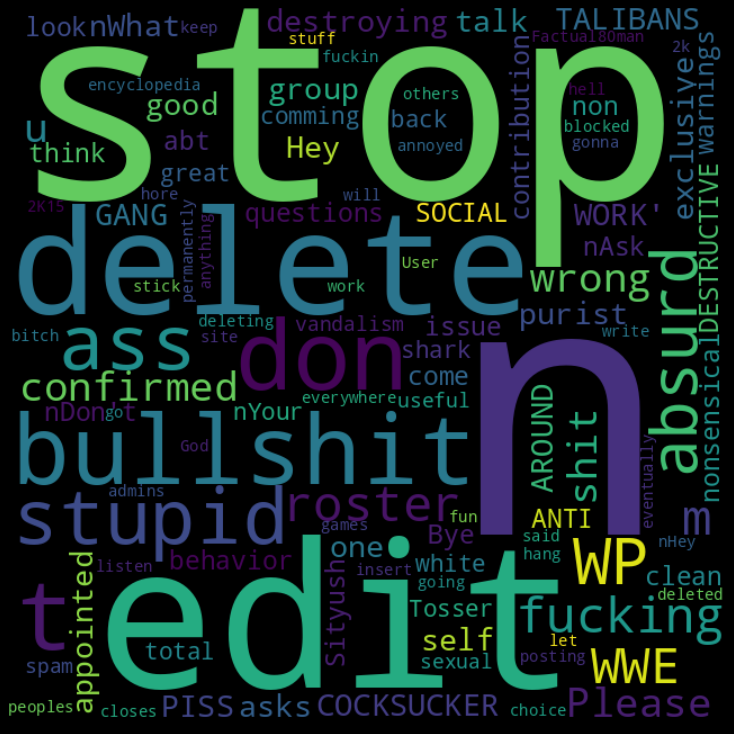

In [5]:
# Create and generate a WordCloud image with toxic comments
comments = train_df['comment_text'].loc[train_df['toxic']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))

# Display the generated image
fig = plt.figure(
    figsize = (15, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show() 

In [6]:
y = train_df['toxic'].values
print(y)

[0 0 0 ... 0 0 0]


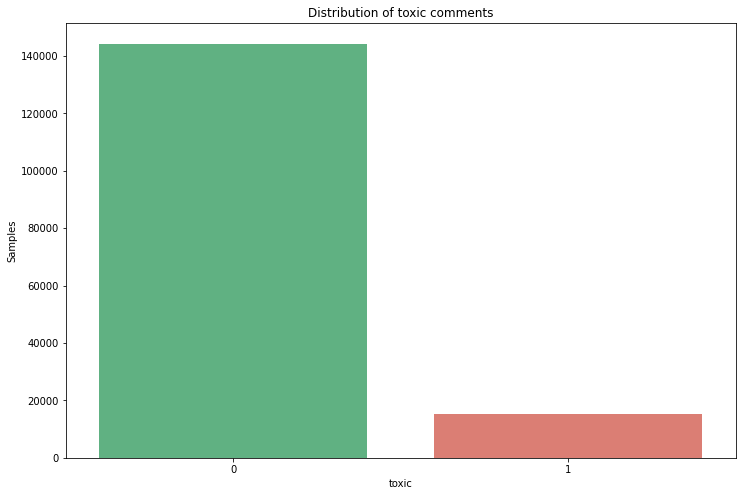

In [7]:
# Plot frequency of toxic comments (0 = not toxic, 1 = toxic)
green = '#52BE80'
red = '#EC7063'

plt.figure(figsize=(12,8))
ax = sns.countplot(train_df['toxic'], palette=[green, red]) 
ax.set_title('Distribution of toxic comments')
ax.set_ylabel('Samples');

In [8]:
# Counts of comments (0 = not toxic, 1 = toxic)
train_df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

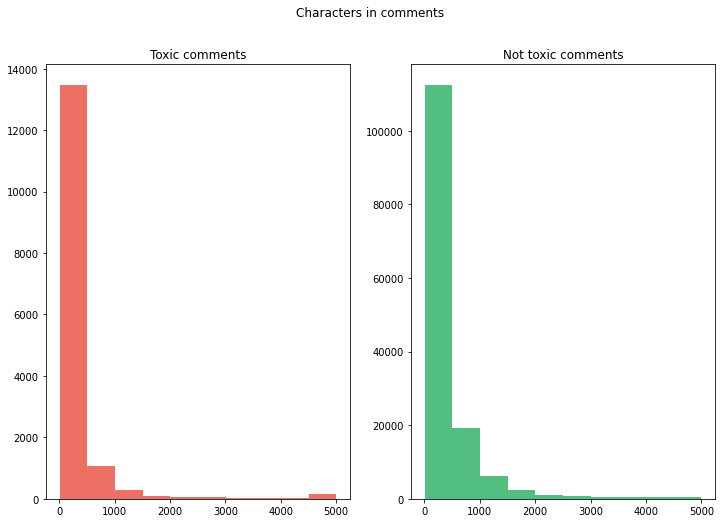

In [9]:
# Number of carachters in comments
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
comment_len=train_df[train_df['toxic']==1]['comment_text'].str.len()
ax1.hist(comment_len,color=red)
ax1.set_title('Toxic comments')

comment_len=train_df[train_df['toxic']==0]['comment_text'].str.len()
ax2.hist(comment_len,color=green)
ax2.set_title('Not toxic comments')
fig.suptitle('Characters in comments')
plt.show()

The distribution of both seems to be almost same. Until 500 characters in a comment are the most common among both.

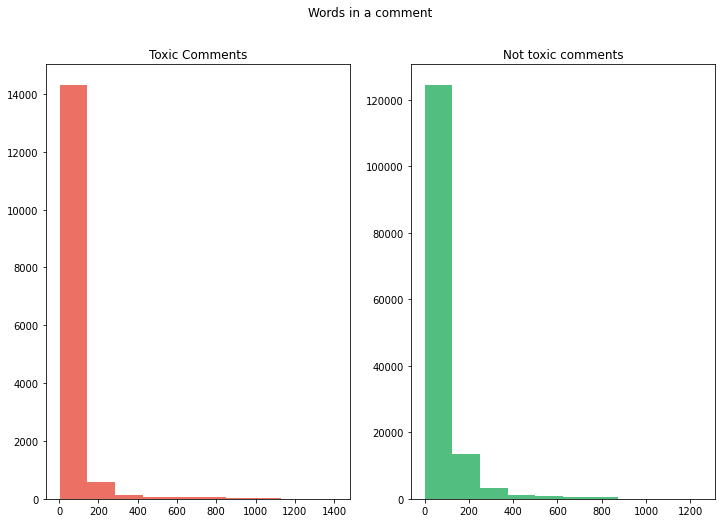

In [10]:
# Number of words in a comment
fig,(ax1,ax2)=plt.subplots(1,2,figsize = (12,8))
comment_len=train_df[train_df['toxic']==1]['comment_text'].str.split().map(lambda x: len(x))
ax1.hist(comment_len,color = red)
ax1.set_title('Toxic Comments')

comment_len=train_df[train_df['toxic']==0]['comment_text'].str.split().map(lambda x: len(x))
ax2.hist(comment_len,color = green)
ax2.set_title('Not toxic comments')
fig.suptitle('Words in a comment')
plt.show()

### Tokenization and Text Data Preparation 

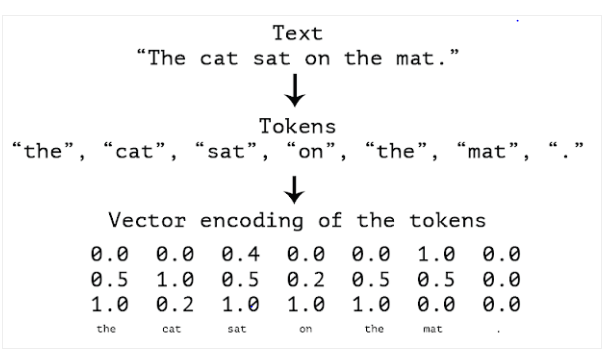

Source: https://freecontent.manning.com/deep-learning-for-text/

In [11]:
# Define some hyperparameters for performing tokenization
max_features = 20000 
max_text_length = 100

x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val = sequence.pad_sequences(x_tokenized, maxlen = max_text_length)

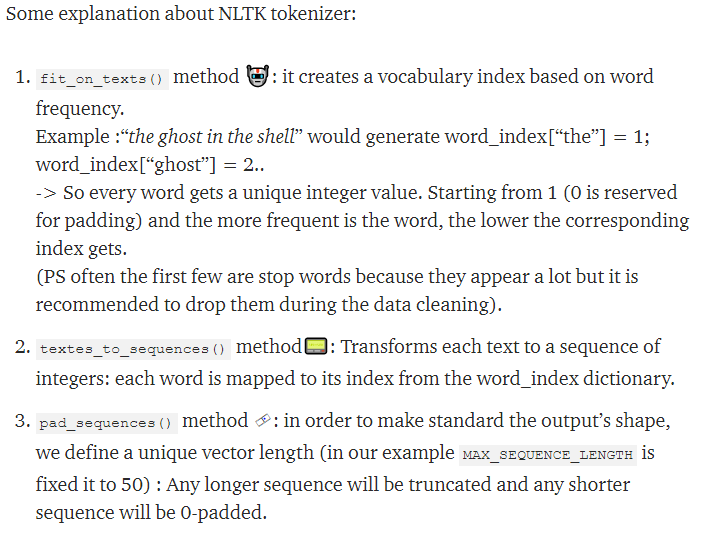

Source: https://towardsdatascience.com/pre-trained-word-embedding-for-text-classification-end2end-approach-5fbf5cd8aead

### Prepare Embedding Matrix with Pre-trained GloVe (Global Vectors) Embeddings

TensorFlow enables to train word embeddings. However, this process not only requires a lot of data but can also be time and resource-intensive. 
To tackle these challenges we'll use pre-trained word embeddings. 

The first step is to obtain the word embedding and append them to a dictionary. After that, we'll need to create an embedding matrix for each word in the training set. 

Let's start by downloading the GloVe word embeddings. After that is to create that dictionary with those embeddings. Let's work with the glove.6B.100d.tx embeddings. The 100 in the name is the same as the maximum length chosen for the sequences.The next step is to create a word embedding matrix for each word in the word index that was obtained earlier. If a word doesn't have an embedding in GloVe it will be presented with a zero matrix.

In [12]:
embedding_dim = 100
embeddings_index = dict()

f = open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Then we will create an embedding matrix that maps each word index to its corresponding embedding vector:

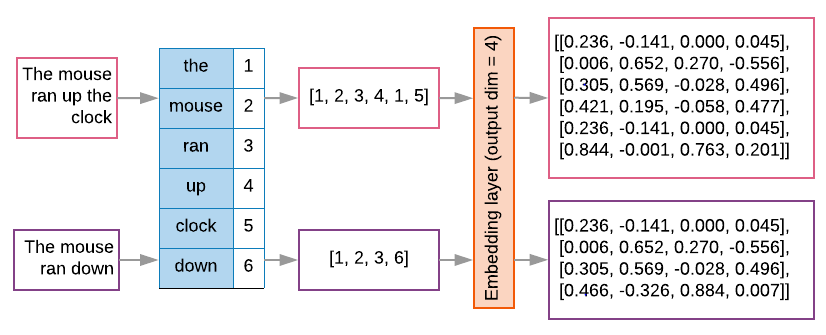

Source: https://developers.google.com/machine-learning/guides/text-classification/images/EmbeddingLayer.png

In [13]:
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index > max_features -1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [14]:
# Here is what the word embedding for the word 'stop' looks like
embeddings_index.get('stop')

array([ 0.2425   , -0.47787  , -0.13228  , -0.067827 ,  0.18656  ,
        0.50566  , -0.6272   ,  0.62262  ,  0.46563  , -0.2013   ,
        0.10606  , -0.0074248,  0.018328 ,  0.071007 , -0.10155  ,
        0.047794 , -0.23775  , -0.031302 , -0.49632  ,  0.15608  ,
        0.66928  ,  0.25275  , -0.13324  , -0.38499  ,  0.066809 ,
        0.77926  , -0.60947  , -0.2793   ,  0.89159  , -0.014682 ,
       -0.47358  ,  0.46668  ,  0.27529  ,  0.22201  , -0.28549  ,
       -0.32237  , -0.016588 , -0.75657  ,  0.57294  ,  0.019744 ,
       -0.70022  ,  0.21178  , -0.051869 , -0.38181  , -0.059082 ,
        0.31623  ,  0.11617  , -0.50781  , -0.23866  , -0.83731  ,
        0.4407   ,  0.3665   , -0.29323  ,  1.1963   , -0.10997  ,
       -2.1168   , -0.20417  ,  0.094542 ,  1.9624   , -0.057167 ,
       -0.3005   , -0.17937  ,  0.24791  ,  0.0021858,  0.68972  ,
        0.59606  ,  0.46632  ,  0.35762  , -0.42129  , -0.32616  ,
       -0.50294  , -1.0584   , -0.40357  , -0.71748  ,  0.0178

### Create the Embedding Layer 

In [16]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(
                    embedding_matrix), trainable=False))
model.add(Dropout(0.2))

### Build the Model

In [17]:
# Define parameters
filters = 150
kernel_size = 3
hidden_dims = 150

In [18]:
model.add(Conv1D(filters, kernel_size, activation = 'relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters, kernel_size, activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'sigmoid'))

# Display the model structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 150)         45150     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 150)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 150)         67650     
_________________________________________________________________
global_max_pooling1d (Global (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 150)              

In [19]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training Model

In [20]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y, test_size = 0.30, random_state = 1235)

In [21]:
# Train the model, iterating on the data in batches of 64 samples
%time
batch_size = 64
epochs = 10

model.fit(x_train, y_train, batch_size = batch_size,
          epochs = epochs, validation_data=(x_val, y_val))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
Epoch 1/10


2022-11-21 13:13:09.841777: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-21 13:13:11.501969: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1746/1746 [==============================] - 16s 5ms/step - loss: 0.1546 - accuracy: 0.9437 - val_loss: 0.1294 - val_accuracy: 0.9525
Epoch 2/10
1746/1746 [==============================] - 8s 5ms/step - loss: 0.1270 - accuracy: 0.9531 - val_loss: 0.1218 - val_accuracy: 0.9559
Epoch 3/10
1746/1746 [==============================] - 8s 4ms/step - loss: 0.1163 - accuracy: 0.9568 - val_loss: 0.1155 - val_accuracy: 0.9574
Epoch 4/10
1746/1746 [==============================] - 8s 5ms/step - loss: 0.1087 - accuracy: 0.9599 - val_loss: 0.1111 - val_accuracy: 0.9588
Epoch 5/10
1746/1746 [==============================] - 8s 5ms/step - loss: 0.1023 - accuracy: 0.9610 - val_loss: 0.1146 - val_accuracy: 0.9577
Epoch 6/10
1746/1746 [==============================] - 8s 5ms/step - loss: 0.0964 - accuracy: 0.9637 - val_loss: 0.1199 - val_accuracy: 0.9555
Epoch 7/10
1746/1746 [==============================] - 8s 4ms/step - loss: 0.0921 - accuracy: 0.9650 - val_loss: 0.1168 - val_accuracy: 0.9575
Ep

### Evaluation Model

In [22]:
test_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

x_test = test_df['comment_text'].values
print(x_test)

["Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"
 '== From RfC == \n\n The title is fine as it is, IMO.'
 '" \n\n == Sources == \n\n * Zawe Ashton on Lapland —  /  "' ...
 '" \n\n == Okinotorishima categories == \n\n I see your changes and agree this is ""more correct.""  I had gotten confused, but then found this: \n :... while acknowledging Japan\'s territorial rights to Okinotorishima itself ... \n However, is there a category for  \n :... did not acknowledge Japan\'s claim to an exclusive economic zone (EEZ) stemming from Okinotorishima. \n That is, is there a category for ""disputed EEZ""s?   "'
 '" \n\n == ""One of the founding nations of the EU - Germany - has a 

In [23]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)

y_testing = model.predict(x_testing, verbose=1, batch_size=64)

2394/2394 [==============================] - 3s 1ms/step


In [24]:
y_testing.shape

(153164, 1)

In [25]:
test_df['Toxic'] = ['not toxic' if x < .5 else 'toxic' for x in y_testing]
test_df[['comment_text', 'Toxic']].head(10) 

,comment_text,Toxic
0,Yo bitch Ja Rule is more succesful then you'll...,toxic
1,== From RfC == \n\n The title is fine as it is...,not toxic
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",not toxic
3,":If you have a look back at the source, the in...",not toxic
4,I don't anonymously edit articles at all.,not toxic
5,Thank you for understanding. I think very high...,not toxic
6,Please do not add nonsense to Wikipedia. Such ...,not toxic
7,:Dear god this site is horrible.,toxic
8,""" \n Only a fool can believe in such numbers. ...",toxic
9,== Double Redirects == \n\n When fixing double...,not toxic


### 👍 ❤️ If you find this notebook useful, I would appreciate an upvote! ❤️ 👍
